In [1]:
import torch
import torch.nn as nn
from torchvision.models import alexnet
from torchvision.models import vgg11
from torchvision.models import googlenet
from torchvision.models import resnet18
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
dataset_train = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, download=True)

means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())

Files already downloaded and verified
cuda:0
NVIDIA GeForce RTX 3080


In [4]:

from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [5]:

@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [6]:

from IPython.display import clear_output

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [7]:

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if valid_accuracy >= 0.905:
            break

In [8]:
def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool = True):

    if model_name == 'resnet18':

        model = resnet18(pretrained=pretrained)
        model.fc = nn.Linear(in_features=512, out_features=num_classes)

    elif model_name == 'alexnet':

        model = alexnet(pretrained=pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    elif model_name == 'vgg11':

        model = vgg11(pretrained=pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    elif model_name == 'googlenet':
        
        if pretrained:
            
            model = googlenet(pretrained=pretrained)
            model.fc = nn.Linear(in_features=1024, out_features=num_classes)
            
        else:
            
            model = googlenet(pretrained=pretrained)
            model.aux1.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
            model.aux2.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
            model.fc = nn.Linear(in_features=1024, out_features=num_classes)

    return model


In [9]:
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()

    prediction = []
    
    for i in range(iterations):
        
        single_prediction = []
        
        with torch.no_grad():
            
            for x,y in loader:
                
                x,y = x.to(device), y.to(device)
                output = model(x)
                single_prediction.append(output)
        prediction.append(torch.vstack(single_prediction))
        
    result = torch.stack(prediction).mean(dim=0)
    
    return torch.argmax(result, dim=1)




In [10]:
def whole_train_valid_cycle_with_schedule(model, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    
    valid_accuracy = 0
    num_epochs = 0
    

    while valid_accuracy < 0.905:
        
        num_epochs += 1 
        
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            f'{title}, {num_epochs} epoch'
        )
        
        scheduler.step()

In [11]:
class Model_With_SkipConn(nn.Module):

    def __init__(self):
        super().__init__()
        # далее идут блоки вашей архитектуры
        self.block_1 = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU()

        )

        self.block_2 = nn.Sequential(

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  # 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU()

        )

        self.block_3 = nn.Sequential(
            nn.MaxPool2d(2),  # 16 x 16 x 64
            nn.Dropout2d(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.block_4 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 16 x 16 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()

        )

        self.block_5 = nn.Sequential(

            nn.MaxPool2d(2),  # 8 x 8 x 128
            nn.Dropout2d(p=0.2),


        )

        self.block_6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 8 x 8 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        
        self.block_7 = nn.Sequential(

            nn.MaxPool2d(2),  # 4 x 4 x 128
            nn.Dropout2d(p=0.2),

        )

        self.block_8 = nn.Sequential(

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),  # 4 x 4 x 128
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.block_9 = nn.Sequential(

            nn.Flatten(),

            nn.Linear(4 * 4 * 128, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x) + x
        x = self.block_5(x)
        x = self.block_6(x) + x
        x = self.block_7(x)
        x = self.block_8(x)
        x = self.block_9(x)

        return x

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.res1 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128),
                                  nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(128))

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.res2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512),
                                  nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                  nn.ReLU(),
                                  nn.BatchNorm2d(512))

        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.res1(out) + out
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)


In [17]:
train_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=True, transform=train_transforms)
valid_dataset = CIFAR10('/home/jupyter/mnt/datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [18]:
#model = Model_With_SkipConn().to(device)

model = ResNet9(3, 10)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25)

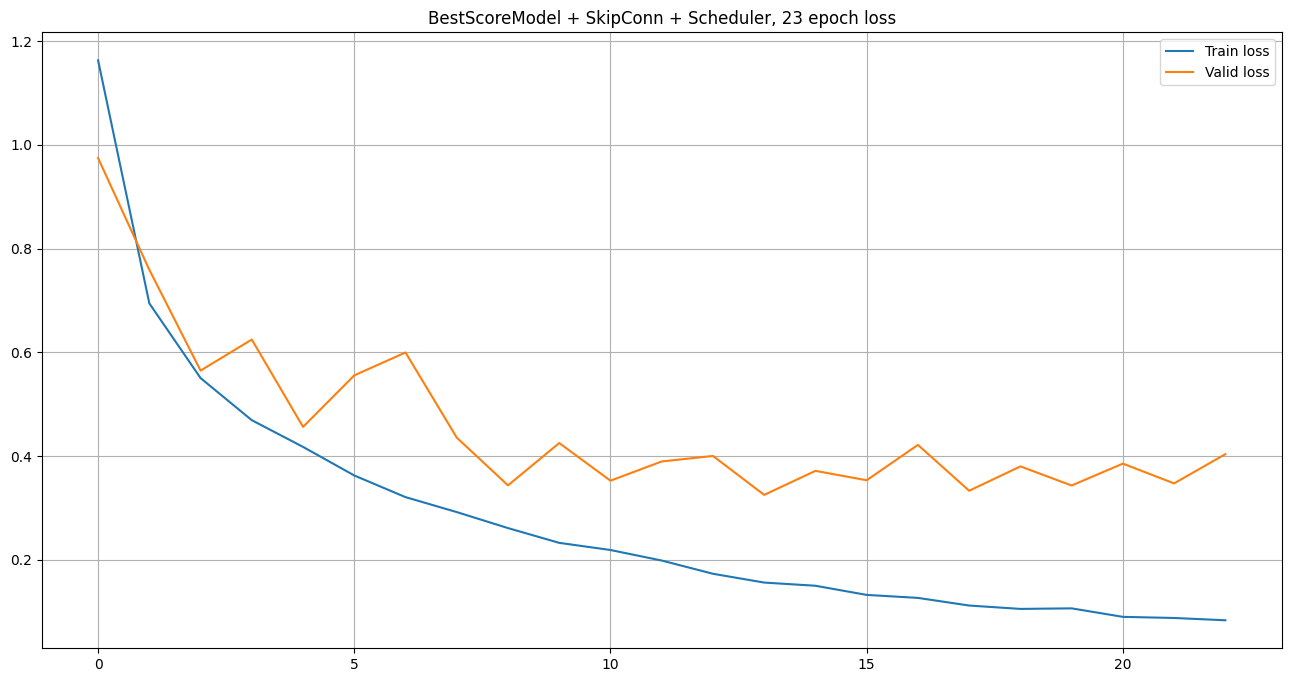

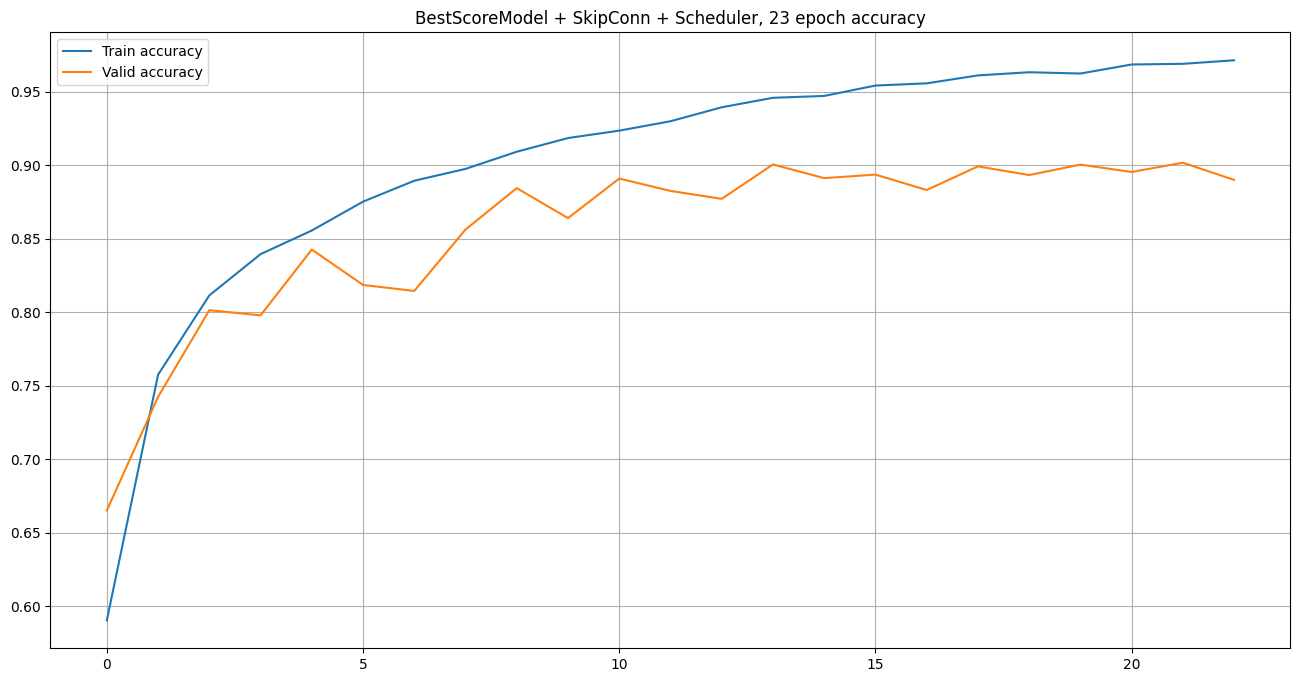

Evaluation:   0%|          | 0/79 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [19]:
whole_train_valid_cycle_with_schedule(model,'BestScoreModel + SkipConn + Scheduler')